Classify accreted star particles in the FIRE Milky Way simulation. 

If a star particle is accreted into the host galaxy, we would like to know the properties of the accretion, such as the merger time (redshift) and the stellar mass of the original subhalo. Unfortunately, tracing star particles to their original subhalo is not trivial, so we do not have access to this information for all accreted star particles.

In [22]:
import os
import h5py
import json

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

%matplotlib inline

mpl.rc('font', size=20)
mpl.rc('figure', figsize=(8, 5), facecolor='w')
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [24]:
# use pandas to read CSV tabel with the accretion history of stars 
df = pd.read_csv('../accretion_table/stars_accretion_history_m12f_v1.csv')
df

,Unnamed: 0,Unnamed: 0.1,feH,id_stars,radial_distance_stars,redshift_stars,snap_list_stars,star_mass,subhalo_mass_stars,subhalo_stellar_mass_stars,...,vrstar,vthetastar,vxstar,vystar,vzstar,xstar,ystar,zstar,subhalo_infall_mass_stars,subhalo_infall_stellar_mass_stars
0,0,0,-0.708981,88687,2.209481,0.090278,539,4917.081240,1.678063e+08,2.769474e+05,...,-330.664154,-225.381226,219.426285,248.657684,258.898651,-1.982948,-0.946444,-0.232309,21424500736,110149616
1,1,1,-0.305655,665325,2.835378,0.090278,539,5237.638446,1.678063e+08,2.769474e+05,...,-184.788177,-35.034519,-126.803757,134.372711,77.980324,0.996590,-2.567369,-0.674384,21424500736,110149616
2,2,2,-0.298712,808755,2.489841,0.090278,539,5763.864372,1.678063e+08,2.769474e+05,...,257.490784,-99.173912,-58.516312,213.341736,171.069077,-1.086775,2.114969,0.738333,21424500736,110149616
3,3,3,-1.202453,865283,3.739644,0.090278,539,4883.673991,1.678063e+08,2.769474e+05,...,-303.876495,-22.654697,98.183357,-311.456909,68.402306,-2.477749,2.743193,-0.566205,21424500736,110149616
4,4,4,-0.327608,1208990,13.555010,0.090278,539,5985.167866,1.678063e+08,2.769474e+05,...,96.866829,54.160789,-101.937225,-31.359821,-66.909790,-8.453577,-10.432305,-1.855356,21424500736,110149616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460596,460596,460596,-3.097388,10378874,5.752827,9.000000,26,4440.305040,1.119088e+09,2.693834e+06,...,-166.640137,112.594421,-25.898632,278.817078,-58.491886,4.326123,-3.392062,-1.695168,1119088256,2693834
460597,460597,460597,-3.873608,14443858,3.037038,9.000000,26,4791.673079,1.119088e+09,2.693834e+06,...,288.891052,161.019592,-51.166878,-351.117249,-239.249634,-2.466594,-1.527381,-0.898124,1119088256,2693834
460598,460598,460598,-3.873608,15488294,4.135688,9.000000,26,5093.361023,1.119088e+09,2.693834e+06,...,103.758011,300.174988,-16.595673,83.463341,-306.611786,-1.712061,3.753869,-0.285010,1119088256,2693834
460599,460599,460599,-2.209216,15742983,2.685117,9.000000,26,5067.988371,4.552707e+08,5.187919e+05,...,23.542889,316.108978,111.871735,179.134323,-316.462891,-2.370720,1.210448,-0.352645,455270656,518791


In [25]:
out_file = '../labels_mapping/m12f/accreted_stellar_mass_all.hdf5'

# Read in the properties of each stars
properties = [
    'id_stars', 'subhalo_mass_stars', 'subhalo_stellar_mass_stars', 
    'subhalo_infall_mass_stars', 'subhalo_infall_stellar_mass_stars', 
    'redshift_stars', 'feH', 'radial_distance_stars', 'xstar', 'ystar', 'zstar',
    'star_mass'
]
temp = df[properties].to_numpy()
data = {}
for i, prop in enumerate(properties):
    data[prop] = temp[:, i]

# We will apply multiple cuts to our data to ensure the best data quality
mask = True
    
# cut out all stars with FeH < -3.5, since FeH = 4 is the default lower bound
mask = mask & (data['feH'] > -3.5)
    
# below 10^9 solar mass, FIRE does not have sufficient mass resolution, 
# so we want to consider only stars with subhalo mass above 10^9
# mask = mask & (data['subhalo_mass_stars'] > 1e9)
# solar neighborhood
# mask = mask & (np.abs(data['zstar']) < 1.5) & (np.abs(data['radial_distance_stars'] - 8) < 2)
# mask = mask & (data['redshift_stars'] < 2.99)   # cut out older mergers

for k, v, in data.items():
    data[k] = v[mask]

In [26]:
[np.isnan(data[prop]).sum() for prop in properties]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

First, we group stars by mergers based on their subhalo infall masses. Stars with the same subhalo infall mass are considered from the same merger.

Some halos have gotten stars associated with them at slightly different snapshots, so they could have the same subhalo infall mass, but not the same stellar mass or halo mass.

In [27]:
subhalo_properties = (
    'subhalo_infall_mass_stars', 'subhalo_infall_stellar_mass_stars',
    'subhalo_mass_stars', 'subhalo_stellar_mass_stars',
    'redshift_stars', 'feH', 'star_mass'
)

infall_mass_mergers, count_mergers = np.unique(
    data['subhalo_infall_mass_stars'], return_counts=True)
N_mergers = len(count_mergers)


# get properties of each merger
data_mergers = {}
for prop in subhalo_properties:
    data_mergers[prop] = np.zeros(N_mergers)
data_mergers['subhalo_infall_mass_stars'] = infall_mass_mergers

for i in range(N_mergers):
    
    # query stars from the same merger
    mask = data['subhalo_infall_mass_stars'] == infall_mass_mergers[i]
    assert np.sum(mask) == count_mergers[i]
    
    for prop in subhalo_properties:
        if prop == 'subhalo_infall_mass_stars':
            continue
        elif prop == 'star_mass':
            data_mergers[prop][i] = np.nansum(data[prop][mask])
        else:
            data_mergers[prop][i] = np.nanmean(data[prop][mask])

In [28]:
# sort by infall mass
# mask = np.argsort(data_mergers['subhalo_infall_mass_stars'])[::-1]
# sort by peak mass
mask = np.argsort(count_mergers)[::-1]
for prop in subhalo_properties:
    data_mergers[prop] = data_mergers[prop][mask]
count_mergers = count_mergers[mask]

print('Infall mass, number of stars:')
print('------------')
for i in range(N_mergers):
    print('{:8.3g} {:d}'. format(data_mergers['subhalo_infall_mass_stars'][i], count_mergers[i]))

Infall mass, number of stars:
------------
5.98e+08 134264
3.82e+08 121945
7.43e+10 71641
1.82e+10 27437
2.37e+10 24536
3.03e+10 21565
1.95e+09 11872
3.65e+09 11050
4.22e+09 5544
4.41e+09 4852
1.27e+11 3169
4.43e+09 2469
2.82e+09 2232
2.06e+10 2095
8.06e+10 1553
1.21e+09 1539
2.14e+10 1212
4.14e+09 1128
3.86e+08 899
7.99e+10 654
   2e+08 531
2.18e+09 483
2.54e+09 448
1.93e+09 409
1.49e+11 287
8.77e+08 271
1.17e+08 213
1.04e+09 213
1.64e+09 210
1.11e+10 208
9.18e+08 206
3.25e+10 200
3.23e+09 194
1.43e+09 184
 2.8e+09 170
2.12e+09 161
 7.7e+09 147
5.28e+08 131
1.31e+10 126
 2.6e+10 110
7.31e+08 107
7.63e+09 99
6.69e+10 95
1.42e+11 94
3.83e+09 88
3.06e+09 85
5.51e+09 67
2.07e+09 67
3.55e+09 62
1.54e+08 58
1.35e+08 47
 1.3e+11 44
1.12e+09 33
8.08e+08 33
2.03e+10 32
1.46e+07 29
6.99e+07 29
1.74e+08 28
3.16e+08 28
1.83e+09 28
2.27e+10 27
6.99e+08 26
6.98e+09 26
   1e+11 26
5.78e+08 25
8.19e+08 25
2.36e+08 22
8.76e+08 21
1.15e+08 20
8.29e+08 19
1.06e+11 19
1.81e+07 19
 4.5e+08 18
5.67e+07 18


Now, we fit the present-day stellar mass-metallicity ($M_{\star, \rm{total}} - \langle[\rm{Fe}/\rm{H}]\rangle$) relation to the host galaxy m12i. To compare with the previous results from [10.3847/1538-4357/ab3afc](https://iopscience.iop.org/article/10.3847/1538-4357/ab3afc), we will also fit the peak halo mass-stellar mass ($M_\rm{peak} - M_{\star, \rm{total}}$) and mass-to-light ratio-metallicity ($\log(M_\rm{peak}/M_{\star, \rm{total}}) - \langle[\rm{Fe}/\rm{H}]\rangle$) relations.

These are simple linear relatio, so we will use `np.polyfit`.

In [29]:
mask = count_mergers > 0 # flag to exclude mergers with too few stars

# fit stellar mass-metallicity relation
x = data_mergers['feH'][mask]
y = np.log10(data_mergers['subhalo_stellar_mass_stars'][mask])
mm_best_fits = np.polyfit(x, y, 1)
m12i_mm_fn = lambda feh: feh * mm_best_fits[0] + mm_best_fits[1]

# fit peak halo mass-stellar mass relation
x = np.log10(data_mergers['subhalo_stellar_mass_stars'][mask])
y = np.log10(data_mergers['subhalo_infall_mass_stars'][mask])

peakmm_best_fits = np.polyfit(x, y, 1)
m12i_peakmm_fn = lambda log_stellar_m: log_stellar_m * peakmm_best_fits[0] + peakmm_best_fits[1]

# fit mass-to-light ratio-metallicity relation
x = data_mergers['feH'][mask]
y = np.log10(data_mergers['subhalo_infall_mass_stars'] / data_mergers['subhalo_stellar_mass_stars'])
y = y[mask]
rm_best_fits = np.polyfit(x, y, 1)
m12i_rm_fn = lambda feh: feh * rm_best_fits[0] + rm_best_fits[1]

print('The present-day stellar mass-metallicity relation: [a, b] = [{:.4f}, {:.4f}]'.format(
    mm_best_fits[0], mm_best_fits[1]))
print('The peak halo mass-stellar mass rleation: [a, b] = [{:.4f}, {:.4f}]'.format(
    peakmm_best_fits[0], peakmm_best_fits[1]))
print('The mass-to-light ratio-metallicity relation: [a, b] = [{:.4f}, {:.4f}]'.format(
    rm_best_fits[0], rm_best_fits[1]))

The present-day stellar mass-metallicity relation: [a, b] = [1.7284, 10.5004]
The peak halo mass-stellar mass rleation: [a, b] = [0.6954, 4.4117]
The mass-to-light ratio-metallicity relation: [a, b] = [-0.6692, 0.8860]


In [32]:
fit_d = {
    'mass_metallicity': list(mm_best_fits),
    'peak_halo_mass_mass': list(peakmm_best_fits),
    'mass_to_light_ratio_metallicity': list(rm_best_fits)
}
with open('/work/08317/tg876168/stampede2/m12f_fit/accreted_stellar_mass.json', 
          'w') as outfile:
    json.dump(fit_d, outfile, indent=4)

We will also fit the 

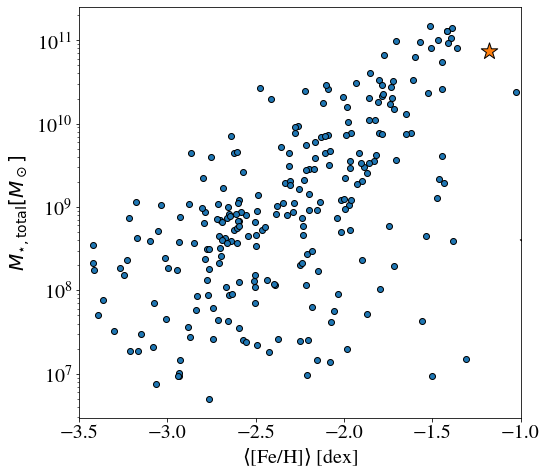

In [33]:
fig, ax = plt.subplots(1, figsize=(8, 7))

mask = count_mergers > 0 
n_star = 3
s = 80

x = data_mergers['feH'][mask]
y = data_mergers['subhalo_infall_mass_stars'][mask]

ax.scatter(x, y, edgecolor='k')
ax.scatter(x[:n_star], y[:n_star], marker ="*", s=300, edgecolors='k')
ax.set_xlim(-3.5, -1)
ax.set_xlabel(r'$\langle$[Fe/H]$\rangle$ [dex]')
ax.set_ylabel(r'$M_{\star, \mathrm{total}} [M_\odot]$')
ax.set_yscale('log')

fig.tight_layout()

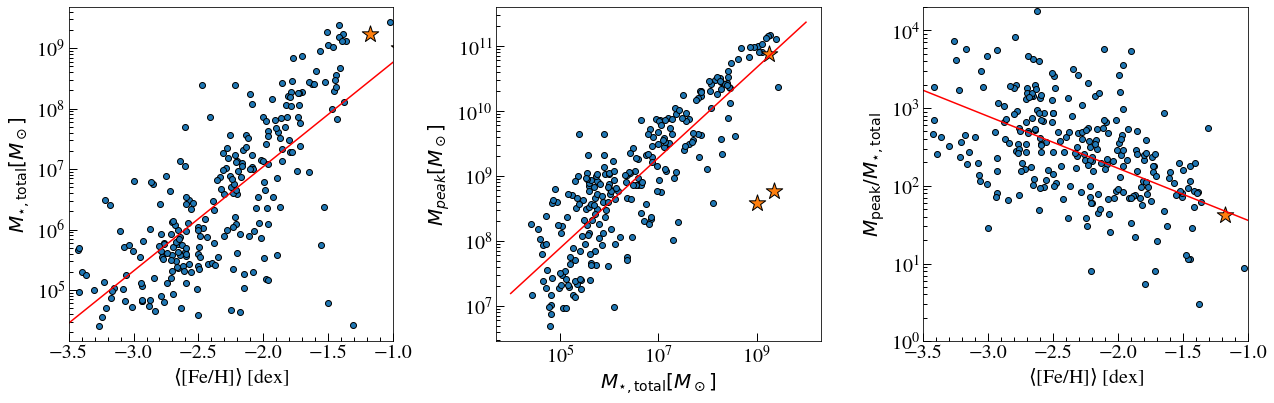

In [34]:
# Set some plotting properties
mask = count_mergers > 0  # minimum number of stars
n_star = 3  # number of mergers to 'star'
s = 80  # size of scatterplot marker

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Format ticks
for ax in (ax1, ax2, ax3):
    ax.minorticks_on()
    ax.tick_params('both', length=8, width=1, which='major', direction='in')
    ax.tick_params('both', length=4, width=1, which='minor', direction='in')

# Plot axis 1: metallicity vs. M_star
x = data_mergers['feH'][mask]
y = data_mergers['subhalo_stellar_mass_stars'][mask]
ax1.scatter(x, y, edgecolor='k')
ax1.scatter(x[:n_star], y[:n_star], marker ="*", s=300, edgecolors='k')

feh = np.linspace(-3.5, -1, 100)
ax1.plot(feh, 10**m12i_mm_fn(feh), c='r')  # fit function
ax1.set_yscale('log')
# ax1.set_ylim(1e5, 4e9)
ax1.set_xlim(-3.5, -1)
ax1.set_xlabel(r'$\langle$[Fe/H]$\rangle$ [dex]')
ax1.set_ylabel(r'$M_{\star, \mathrm{total}} [M_\odot]$')

# Plot axis 2: M_star vs. M_total
x = data_mergers['subhalo_stellar_mass_stars'][mask]
y = data_mergers['subhalo_infall_mass_stars'][mask]
ax2.scatter(x, y, edgecolor='k')
ax2.scatter(x[:n_star], y[:n_star], marker ="*", s=300, edgecolors='k')
ax2.plot(10**np.linspace(4, 10, 100), 
         10**m12i_peakmm_fn(np.linspace(4, 10, 100)), c='r')  # fit function
ax2.set_xscale('log')
ax2.set_yscale('log')
# ax2.set_xlim(1e4, 4e9)
# ax2.set_ylim(1e7, 2e11)
ax2.set_xlabel(r'$M_{\star, \mathrm{total}} [M_\odot]$')
ax2.set_ylabel(r'$M_{peak} [M_\odot]$')

# Plot axis 3: feH vs M_total / M_star
x = data_mergers['feH'][mask]
y = data_mergers['subhalo_infall_mass_stars'] / data_mergers['subhalo_stellar_mass_stars']
y = y[mask]
ax3.scatter(x, y, edgecolor='k') # plot scatter plot
ax3.scatter(x[:n_star], y[:n_star], marker ="*", s=300, edgecolors='k')

feh = np.linspace(-3.5, -1, 100)
ax3.plot(feh, 10**m12i_rm_fn(feh), c='r')  # fit function
ax3.set_xlabel(r'$\langle$[Fe/H]$\rangle$ [dex]')
ax3.set_ylabel(r'$M_\mathrm{peak} / M_{\star, \mathrm{total}}$')
ax3.set_yscale('log')
ax3.set_ylim(1, 2e4)
ax3.set_xlim(-3.5, -1)


fig.tight_layout()

### Label stars by present-day stellar mass

In [35]:
properties, [len(np.unique(data[prop])) for prop in properties]

(['id_stars',
  'subhalo_mass_stars',
  'subhalo_stellar_mass_stars',
  'subhalo_infall_mass_stars',
  'subhalo_infall_stellar_mass_stars',
  'redshift_stars',
  'feH',
  'radial_distance_stars',
  'xstar',
  'ystar',
  'zstar',
  'star_mass'],
 [458739,
  268,
  270,
  251,
  263,
  21,
  452949,
  458661,
  457161,
  457219,
  457546,
  428379])

In [36]:
# Get merger id of each star
data['merger_id'] = np.zeros_like(data['id_stars'])
data['merger_count'] = np.zeros_like(data['id_stars'])
for i in range(N_mergers):
    mask = data['subhalo_infall_mass_stars'] == data_mergers['subhalo_infall_mass_stars'][i]
    data['merger_id'][mask] = i
    data['merger_count'][mask] = count_mergers[i]

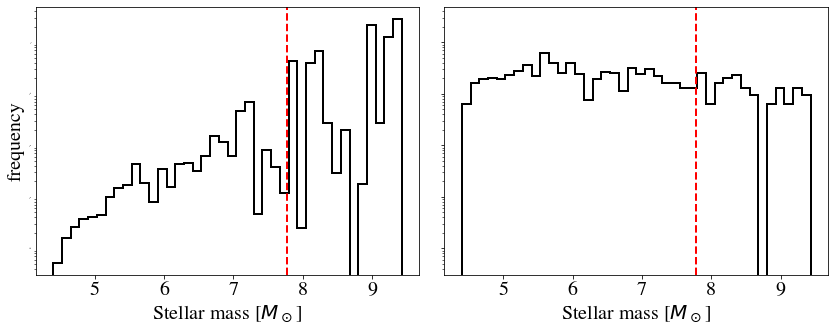

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), 
                               sharex=True, sharey=True)

bins = np.linspace(4, 9, 40)
bins = 40

# plot histogram
ax1.hist(np.log10(data['subhalo_stellar_mass_stars']), bins, density=True,
         color='k', histtype='step', lw=2)
ax1.set_yscale('log')
ax1.set_ylabel('frequency')

# plot histogram weighted each star by the merger size
weights = len(data['merger_count'])/data['merger_count']
ax2.hist(np.log10(data['subhalo_stellar_mass_stars']), bins, weights=weights, density=True,
        color='k', histtype='step', lw=2)
ax2.set_yscale('log')

# plot threshold
thres = 6e7
ax1.axvline(np.log10(thres), color='r', ls='--', lw=2)
ax2.axvline(np.log10(thres), color='r', ls='--', lw=2)

# format axis
ax1.set_xlabel(r'Stellar mass [$M_\odot$]')
ax2.set_xlabel(r'Stellar mass [$M_\odot$]')
ax1.tick_params(axis='y', labelsize=0, length=0)

fig.tight_layout()

In [39]:
labels = data['subhalo_stellar_mass_stars'] > thres
labels = labels.astype(int)
merger_labels = data_mergers['subhalo_stellar_mass_stars'] > thres
merger_labels = merger_labels.astype(int)

print('Number of low mass stars    : {}'.format(np.sum(labels==0)))
print('Number of high mass stars   : {}'.format(np.sum(labels==1)))
print('Number of low mass mergers  : {}'.format(np.sum(merger_labels==0)))
print('Number of high mass mergers : {}'.format(np.sum(merger_labels==1)))
print('Fraction of low mass stars    : {:.4f}'.format(np.sum(labels==0) / len(labels)))
print('Fraction of high mass stars   : {:.4f}'.format(np.sum(labels==1) / len(labels)))
print('Fraction of low mass mergers  : {:.4f}'.format(np.sum(merger_labels==0) / len(merger_labels)))
print('Fraction of high mass mergers : {:.4f}'.format(np.sum(merger_labels==1) / len(merger_labels)))

Number of low mass stars    : 11365
Number of high mass stars   : 447374
Number of low mass mergers  : 200
Number of high mass mergers : 51
Fraction of low mass stars    : 0.0248
Fraction of high mass stars   : 0.9752
Fraction of low mass mergers  : 0.7968
Fraction of high mass mergers : 0.2032


In [41]:
# create label mapping for low-mass (0) and high-mass stars
with h5py.File(out_file, 'w') as f:
    f.attrs.update({
        'label_0': 'low-mass',
        'label_1': 'high-mass',
        'threshold': thres
    })
    
    f.create_dataset('labels', data=labels)
    f.create_dataset('log10_halo_stellar_mass', data=np.log10(data['subhalo_stellar_mass_stars']))    
    f.create_dataset('id_stars', data=data['id_stars'])
    f.create_dataset('merger_count', data=data['merger_count'])

### Label by total mass

In [10]:
properties, [len(np.unique(data[prop])) for prop in properties]

(['id_stars',
  'subhalo_mass_stars',
  'subhalo_stellar_mass_stars',
  'subhalo_infall_mass_stars',
  'subhalo_infall_stellar_mass_stars',
  'redshift_stars',
  'feH',
  'radial_distance_stars',
  'xstar',
  'ystar',
  'zstar',
  'star_mass'],
 [166540, 84, 84, 74, 83, 15, 165406, 166539, 166382, 166378, 166375, 160825])

In [11]:
# Get merger id of each star
data['merger_id'] = np.zeros_like(data['id_stars'])
data['merger_count'] = np.zeros_like(data['id_stars'])
for i in range(N_mergers):
    mask = data['subhalo_infall_mass_stars'] == data_mergers['subhalo_infall_mass_stars'][i]
    data['merger_id'][mask] = i
    data['merger_count'][mask] = count_mergers[i]

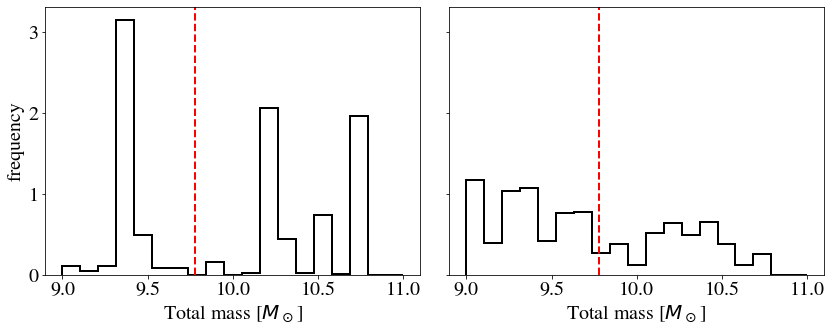

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), 
                               sharex=True, sharey=True)

bins = np.linspace(9, 11, 20)

# plot histogram
ax1.hist(np.log10(data['subhalo_mass_stars']), bins, density=True,
         color='k', histtype='step', lw=2)
# ax1.set_yscale('log')
ax1.set_ylabel('frequency')

# plot histogram weighted each star by the merger size
weights = len(data['merger_count'])/data['merger_count']
ax2.hist(np.log10(data['subhalo_mass_stars']), bins, weights=weights, density=True,
        color='k', histtype='step', lw=2)
# ax2.set_yscale('log')

# plot threshold
thres = 6e9
ax1.axvline(np.log10(thres), color='r', ls='--', lw=2)
ax2.axvline(np.log10(thres), color='r', ls='--', lw=2)

# format axis
ax1.set_xlabel(r'Total mass [$M_\odot$]')
ax2.set_xlabel(r'Total mass [$M_\odot$]')
# ax1.tick_params(axis='y', labelsize=0, length=0)

fig.tight_layout()

In [18]:
labels = data['subhalo_mass_stars'] > thres
labels = labels.astype(int)
merger_labels = data_mergers['subhalo_mass_stars'] > thres
merger_labels = merger_labels.astype(int)

print('Number of low mass stars    : {}'.format(np.sum(labels==0)))
print('Number of high mass stars   : {}'.format(np.sum(labels==1)))
print('Number of low mass mergers  : {}'.format(np.sum(merger_labels==0)))
print('Number of high mass mergers : {}'.format(np.sum(merger_labels==1)))
print('Fraction of low mass stars    : {:.4f}'.format(np.sum(labels==0) / len(labels)))
print('Fraction of high mass stars   : {:.4f}'.format(np.sum(labels==1) / len(labels)))
print('Fraction of low mass mergers  : {:.4f}'.format(np.sum(merger_labels==0) / len(merger_labels)))
print('Fraction of high mass mergers : {:.4f}'.format(np.sum(merger_labels==1) / len(merger_labels)))

Number of low mass stars    : 71401
Number of high mass stars   : 95139
Number of low mass mergers  : 45
Number of high mass mergers : 29
Fraction of low mass stars    : 0.4287
Fraction of high mass stars   : 0.5713
Fraction of low mass mergers  : 0.6081
Fraction of high mass mergers : 0.3919


In [19]:
out_file = '../labels_mapping/accreted_total_mass.hdf5'

# create label mapping for low-mass (0) and high-mass stars
with h5py.File(out_file, 'w') as f:
    f.attrs.update({
        'label_0': 'low-mass',
        'label_1': 'high-mass',
        'threshold': thres
    })
    
    f.create_dataset('labels', data=labels)
    f.create_dataset('log10_halo_mass', data=np.log10(data['subhalo_mass_stars']))
    f.create_dataset('id_stars', data=data['id_stars'])
    f.create_dataset('merger_count', data=data['merger_count'])